# Training GAN to generate pixel characters and items

In [1]:
path='./'
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
!ls $path

data	    models   test_GAN_one_iter.cpython-310-x86_64-linux-gnu.so	utils
main.ipynb  results  train


## Import package and set serveral configs

In [9]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import sqrt

from models.gan import Discriminator, Generator
from models.cgan import cDiscriminator, cGenerator
from data.dataloader import GANdataloader
from train.train import *

from utils.fid_metric import calculate_fid
from utils.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
# torch.cuda.get_device_name(0)

'cuda'

In [5]:
from types import SimpleNamespace

config = SimpleNamespace(
    seed = 42, 
    input_shape = (3,16,16), 
    num_classes = 5, 
    nc = 3, 
    test_batch_size = 64, 
    latent_dim =100, 

    epoch = 20,
    batch_size = 256,
    lr = 1e-3,
)


In [6]:
# set randomness
set_randomness(config.seed)

# Generative Adversarial Network

GAN consists of two networks, ***Generator and Discriminator***.



## 1.1 Generator in Generative Adversarial Network
First, let's implement generator. The generator for GAN is as follows:
- Generator : $G(z) = x$
    - $z$ : Latent vector `(batch_size, latent_dim)`
    - $x$ : Fake image `(batch_size, 1, 16, 16)`



In [10]:
gen = Generator(latent_dim = config.latent_dim,nc = config.nc).to(device)
print(gen)
# print(config.batch_size)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (conv_transpose): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Tanh()
  )
)


In [11]:
# check the number of parameters
print("The number of model parameters: ", sum(p.numel() for p in gen.parameters() if p.requires_grad))

The number of model parameters:  1089539


### 1.1.2 forward
The forward function take input of the batch of latent vector and return output of the batch of (fake) image.

In [12]:

z = torch.randn(config.batch_size, config.latent_dim).to(device)
out = gen(z)
print(out.shape)
assert out.shape == (config.batch_size, config.nc, *config.input_shape[1:]), f"Wrong output shape from the generator (expected {(config.batch_size, config.nc, *config.input_shape[1:])}, got {out.shape})"

torch.Size([256, 3, 16, 16])



## 1.2 Discriminator in Generative Adversarial Network


In [17]:
dis = Discriminator(nc=config.nc).to(device)
print(dis)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)


In [18]:
# check the number of parameters
print("The number of model parameters: ",  sum(p.numel() for p in dis.parameters() if p.requires_grad))

The number of model parameters:  434369


### 1.2.2 forward
The forward method takes as input a batch of images and returns the probability of being real for each image in the batch.


In [19]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
out = gen(z)
out1 = dis(out)
print(out1.shape)
assert (out1.shape == torch.Size([config.batch_size, 1])), f"Discriminator output shape is wrong : {out1.shape}"

torch.Size([256, 1])


## 2. Conditional GAN (cGAN)
The conditional GAN (cGAN) is similar to GAN, but it takes label as input with latent vector. 

### 2.1 Generator in cGAN
The generator for cGAN is as below:
- Generator : $G(z,y) = x$
    - $z$ : Latent vector `(batch_size, latent_dim)`
    - $y$ : Label vector `(batch_size, num_classes)`
    - $x$ : Fake image `(batch_size, 1, 16, 16)`


In [48]:
cond_gen = cGenerator(input_shape= config.input_shape,
                 latent_dim=config.latent_dim, num_classes=config.num_classes, nc = config.nc
                ).to(device)
print(cond_gen)

cGenerator(
  (fc): Linear(in_features=105, out_features=768, bias=True)
  (conv_transpose): Sequential(
    (0): ConvTranspose2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [17]:
# check the number of parameters
print("The number of model parameters: ",  sum(p.numel() for p in cond_gen.parameters() if p.requires_grad))

The number of model parameters:  1858947


### 2.1.2 forward
The forward function take input of the batch of latent vector and return output of the batch of (fake) image.
### TODO
- Implement `forward` function in `cGenerator` class (The code in `HW4_2_YourAnswer.py`).

The output has shape (B,C,H,W)

In [18]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
label = torch.zeros(config.batch_size, config.num_classes).scatter_(1, torch.randint(0, config.num_classes, (config.batch_size,1)), 1).to(device)
out = cond_gen(z, label)
print(out.shape)
assert out.shape == (config.batch_size, config.nc, *config.input_shape[1:]), "Wrong output shape from the conditional generator"

torch.Size([256, 3, 16, 16])



## 2.2 Discriminator in Conditional Generative Adversarial Network



In [19]:
cond_dis = cDiscriminator(input_shape = config.input_shape,num_classes=config.num_classes).to(device)
print(cond_dis)

cDiscriminator(
  (label_embedding): Embedding(5, 256)
  (model): Sequential(
    (0): Conv2d(8, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)


In [20]:
# check the number of parameters
print("The number of model parameters: ", sum(p.numel() for p in cond_dis.parameters() if p.requires_grad))

The number of model parameters:  377281


### 2.2.2 forward
The forward method takes a batch of ***images and labels***, then returns output of the probability of being real for each image within the batch.


The output has shape (B, 1).

In [21]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
label = torch.zeros(config.batch_size, config.num_classes).scatter_(1, torch.randint(0, config.num_classes, (config.batch_size,1)), 1).to(device)
out = cond_gen(z,label)
out1 = cond_dis(out,label)
print(out1.shape)
assert (out1.shape == torch.Size([config.batch_size, 1])), f"Discriminator output shape is wrong : {out1.shape}"

torch.Size([256, 1])


# Dataloader for training procedure for GAN
 `GANdataloader` directly feeds the images into GAN networks.
    - It defines batch size, shuffling option, etc.



In [49]:
loader_for_test = GANdataloader(train=False, batch_size=config.batch_size)
print(loader_for_test.transform)

Compose(
    ToTensor()
)


In [55]:
loader_for_test = GANdataloader(train=True, batch_size=10)
for img, label in loader_for_test:
    print(f"The shape of image from the dataloader : {img.shape}")
    print(f"The type of image from the dataloader : {type(img)}")
    print(f"The shape of label from the dataloader : {label.shape}")
    break

The shape of image from the dataloader : torch.Size([10, 3, 16, 16])
The type of image from the dataloader : <class 'torch.Tensor'>
The shape of label from the dataloader : torch.Size([10, 5])


If implemented correctly, the figure is presented with character or item images with label as below.


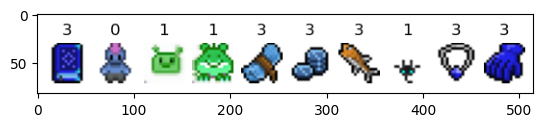

In [58]:
sample_img = cv2.imread("./utils/test_file/sprites_img.png")
plt.imshow(sample_img)
plt.show()

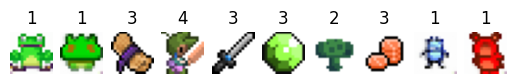

In [59]:

fig = plt.figure()
img = img.numpy().transpose(0,2,3,1)
img = img/255 # for normalisation
label = torch.argmax(label,dim=1).numpy().squeeze()
for i in range(10):
  train_x = img[i]
  train_y = label[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y))
  ax.axis("off")

plt.show()

## 4. Training GAN and cGAN

The training process involves a back-and-forth competition between the generator and the discriminator, with each iteration refining both models until the generator produces high-quality, realistic data.

### 4.1 Loss function

The discriminator and the generator engage in a two-player minimax game with the value function $V(G,D)$ where each player has opposing objective.

$min_G max_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[logD(x)] + \mathbb{E}_{z\sim p_z(z)}[log(1-D(G(z)))]$

The loss function outputs the loss value for each network. It returns the loss value depending on the real image and the fake image.


In [20]:
trainer_test = train_GAN(train_loader = None, \
                                generator = gen, discriminator = dis, \
                                device=device, config = config)
print("===== Optimizer for the generator =====")
print(trainer_test.optimizer_G)
print("===== Optimizer for the discriminator =====")
print(trainer_test.optimizer_D)

===== Optimizer for the generator =====
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
===== Optimizer for the discriminator =====
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### 4.3 Training process for GAN
The GAN training procedure looks as follows:
- Discriminator training :
    - Generate random latent vector
    - Feed the latent vector into generator and get fake image `with no gradient`
    - Feed the fake image into discriminator and get discriminator output
    - Feed the real image into discriminator and get discriminator output
    - Calculate discriminator loss with two discriminator outputs
    - Update discriminator with discriminator loss
- Generator training :
    - Generate random latent vector
    - Feed the latent vector into generator and get fake image
    - Feed the fake image into discriminator and get discriminator output
    - Calculate generator loss with discriminator output
    - Update generator with generator loss

In [21]:
from copy import deepcopy
test_config = deepcopy(config)
test_config.batch_size =2
test_config.lr = 2e-4

results = test_one_iter_train_GAN(train_GAN,test_config,device)

print("Implemented result: \n",results)

Implemented result: 
 {'loss_G': 6.18149471282959, 'loss_D': 0.6787929534912109}


### GAN training sanity check


`train` function in `train_GAN` class will train the GAN model with your implementation. The `train` function will return the trained generator and discriminator model even though the interrupt occurs during the training process.



Epoch [1/10], Step [351/350], Loss_D: 0.064476, Loss_G: 4.792516: 100%|██████████| 350/350 [00:23<00:00, 15.20it/s] 


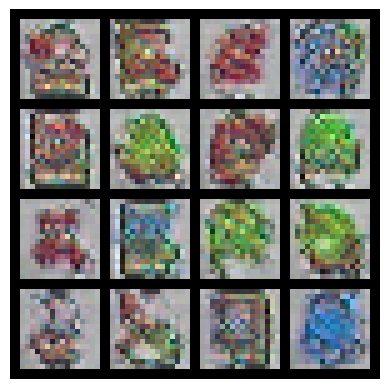

Epoch [2/10], Step [351/350], Loss_D: 0.972578, Loss_G: 1.177156: 100%|██████████| 350/350 [00:22<00:00, 15.47it/s]


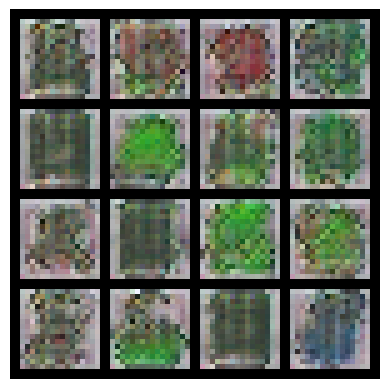

Epoch [3/10], Step [351/350], Loss_D: 0.153218, Loss_G: 2.682711: 100%|██████████| 350/350 [00:22<00:00, 15.47it/s]


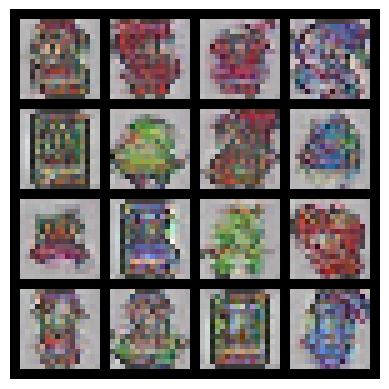

Epoch [4/10], Step [351/350], Loss_D: 0.086517, Loss_G: 4.070985: 100%|██████████| 350/350 [00:23<00:00, 15.10it/s]


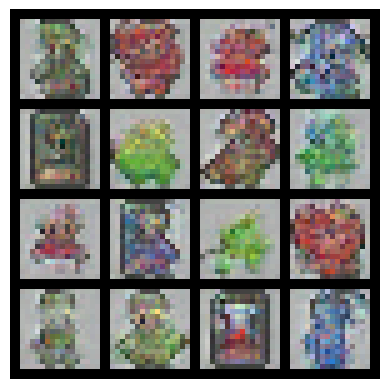

Epoch [5/10], Step [351/350], Loss_D: 0.144757, Loss_G: 4.871521: 100%|██████████| 350/350 [00:22<00:00, 15.48it/s] 


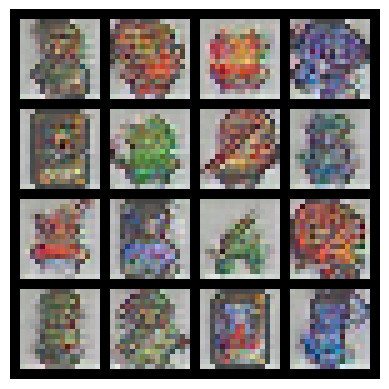

Epoch [6/10], Step [351/350], Loss_D: 0.054390, Loss_G: 4.935125: 100%|██████████| 350/350 [00:22<00:00, 15.32it/s]


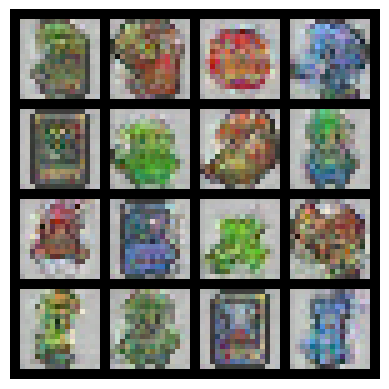

Epoch [7/10], Step [351/350], Loss_D: 0.127243, Loss_G: 2.462180: 100%|██████████| 350/350 [00:23<00:00, 15.00it/s] 


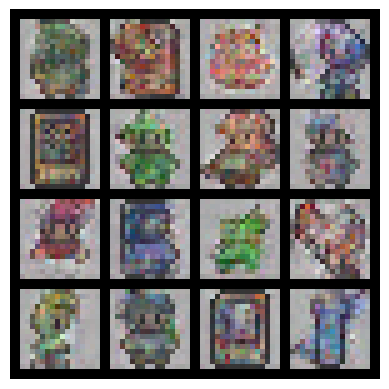

Epoch [8/10], Step [351/350], Loss_D: 0.052744, Loss_G: 4.896541: 100%|██████████| 350/350 [00:22<00:00, 15.53it/s] 


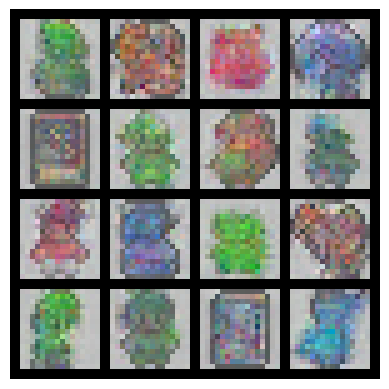

Epoch [9/10], Step [351/350], Loss_D: 0.204916, Loss_G: 3.493357: 100%|██████████| 350/350 [00:22<00:00, 15.36it/s] 


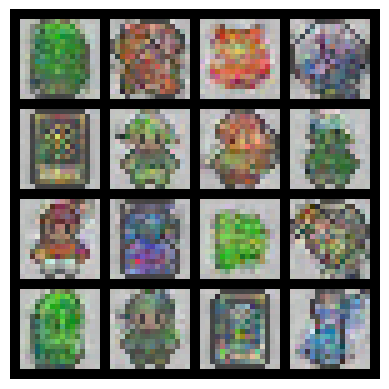

Epoch [10/10], Step [351/350], Loss_D: 0.047660, Loss_G: 2.970202: 100%|██████████| 350/350 [00:22<00:00, 15.42it/s] 


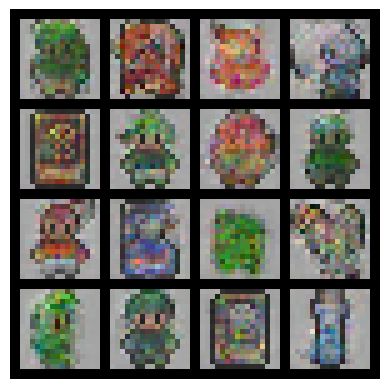

EPOCH 10 - FID score : 46.434886 (evaluation)


In [52]:

test_config = deepcopy(config)
test_config.epoch = 10

train_loader = GANdataloader(train=True, batch_size=test_config.batch_size)

generator = Generator(latent_dim = test_config.latent_dim,nc = test_config.nc).to(device)
discriminator = Discriminator(nc=test_config.nc).to(device)


trainer_test = train_GAN(train_loader, \
                                generator = generator, discriminator = discriminator, \
                                device=device, config = test_config, fid_score_on=False,
                                save_model=False,img_show=True,evaluation_on=True)
results = trainer_test.train()
trained_generator = results['generator']

In [45]:
save_path = "./results/plots/"

In [53]:
# load the trained model and loss history
trained_generator = results['generator']
trained_discriminator = results['discriminator']
loss_G = results['G_loss_history']
loss_D = results['D_loss_history']

### Loss curve of GAN
The generator and discriminator losses are plotted in the same figure.

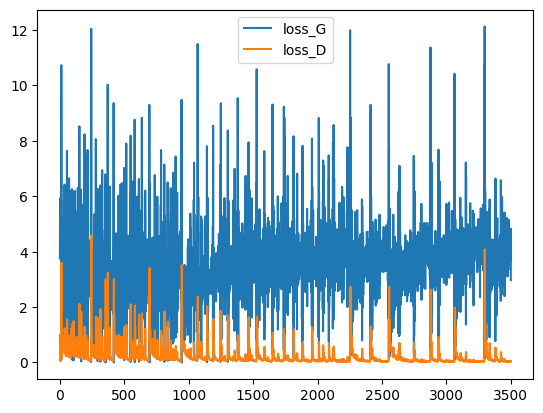

In [54]:
plt.plot(loss_G, label='loss_G')
plt.plot(loss_D, label='loss_D')
plt.legend()
plt.savefig(save_path+"sample_GAN.png")
plt.show()

### Visualization of the output image
Visualization of the output image after light training.

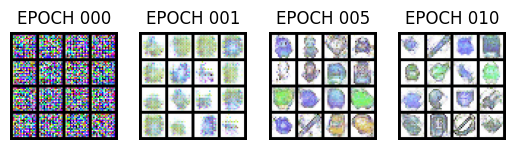

In [55]:
visualizeGAN()

### Visualization of the generated image
- The following output is the result of the GAN training.

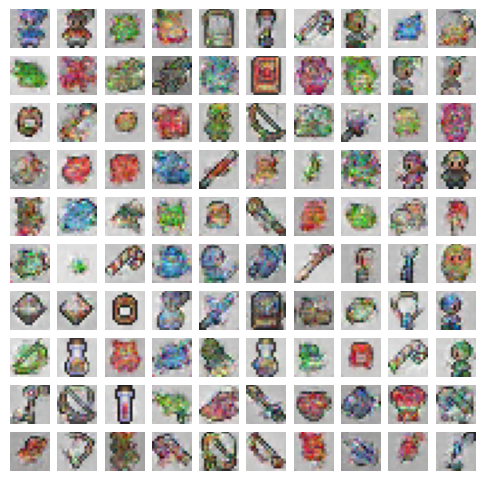

In [56]:
# fake image generation
show_image_with_GAN(trained_generator,config,device=device,cols=10,rows=10)

### 4.4 Training process for conditional GAN
To train conditional GAN, the following steps are required:
- Discriminator training :
    - Generate random latent vector
    - Feed the latent vector and ***label*** into generator and get fake image `with no gradient`
    - Feed the fake image into discriminator and get discriminator output
    - Feed the real image into discriminator and get discriminator output
    - Calculate discriminator loss with two discriminator outputs
    - Update discriminator with discriminator loss
- Generator training :
    - Generate random latent vector
    - Feed the latent vector and ***label*** into generator and get fake image
    - Feed the fake image into discriminator and get discriminator output
    - Calculate generator loss with discriminator output
    - Update generator with generator loss

In [57]:

test_config = deepcopy(config)
test_config.batch_size =2
images = torch.load('./utils/test_file/test_images.pth',map_location=device)
labels = torch.load('./utils/test_file/test_labels.pth',map_location=device)

generator = cGenerator(input_shape= config.input_shape,
                 latent_dim=config.latent_dim,num_classes=config.num_classes, nc = config.nc
                ).to(device)
discriminator = cDiscriminator(input_shape = config.input_shape,num_classes=config.num_classes).to(device)

trainer = train_cGAN(train_loader = None, \
                            generator = generator, discriminator = discriminator, \
                            device=device, config = test_config)

results = trainer.one_iter_train(images,labels)

print("Implementation result: \n",results)


Implementation result: 
 {'loss_G': 5.3134870529174805, 'loss_D': 0.7239410281181335}


### Training conditional GAN 


Epoch [1/20], Step [351/350], Loss_D: 1.618345, Loss_G: 13.173667: 100%|██████████| 350/350 [00:16<00:00, 21.36it/s]


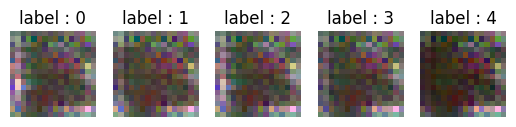

Epoch [2/20], Step [351/350], Loss_D: 0.098471, Loss_G: 8.712619: 100%|██████████| 350/350 [00:15<00:00, 22.15it/s] 


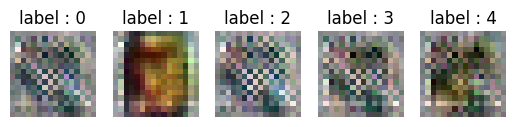

Epoch [3/20], Step [351/350], Loss_D: 0.310553, Loss_G: 1.625577: 100%|██████████| 350/350 [00:16<00:00, 21.45it/s] 


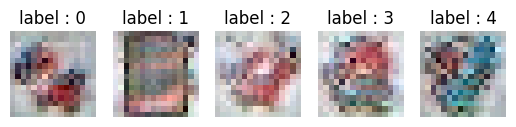

Epoch [4/20], Step [351/350], Loss_D: 0.279956, Loss_G: 1.449865: 100%|██████████| 350/350 [00:15<00:00, 22.71it/s]


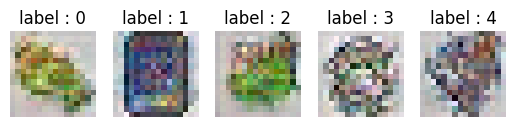

Epoch [5/20], Step [351/350], Loss_D: 0.134096, Loss_G: 4.058582: 100%|██████████| 350/350 [00:16<00:00, 21.38it/s]


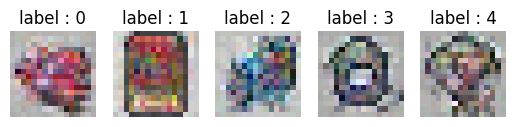

Epoch [6/20], Step [351/350], Loss_D: 0.079643, Loss_G: 3.494451: 100%|██████████| 350/350 [00:15<00:00, 22.12it/s] 


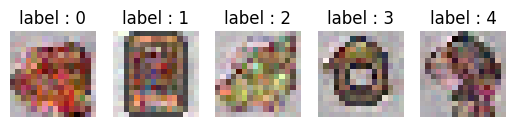

Epoch [7/20], Step [351/350], Loss_D: 0.087373, Loss_G: 3.876310: 100%|██████████| 350/350 [00:16<00:00, 21.37it/s] 


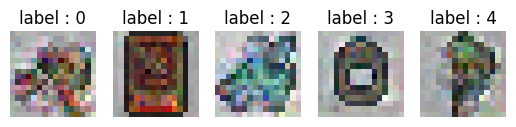

Epoch [8/20], Step [351/350], Loss_D: 0.137863, Loss_G: 2.667342: 100%|██████████| 350/350 [00:15<00:00, 22.45it/s] 


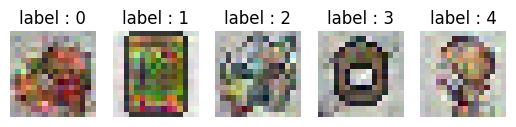

Epoch [9/20], Step [351/350], Loss_D: 0.059519, Loss_G: 3.494449: 100%|██████████| 350/350 [00:15<00:00, 21.92it/s] 


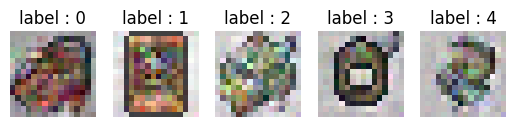

Epoch [10/20], Step [351/350], Loss_D: 0.051659, Loss_G: 3.364249: 100%|██████████| 350/350 [00:15<00:00, 21.93it/s] 


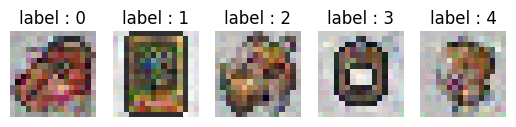

Epoch [11/20], Step [351/350], Loss_D: 0.064150, Loss_G: 3.957261: 100%|██████████| 350/350 [00:16<00:00, 21.63it/s] 


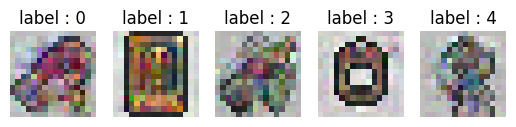

Epoch [12/20], Step [351/350], Loss_D: 0.031927, Loss_G: 4.885147: 100%|██████████| 350/350 [00:15<00:00, 22.08it/s] 


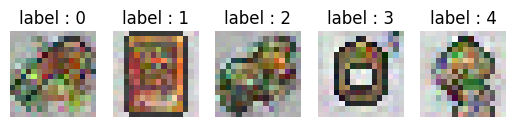

Epoch [13/20], Step [351/350], Loss_D: 0.016013, Loss_G: 6.211596: 100%|██████████| 350/350 [00:16<00:00, 21.83it/s] 


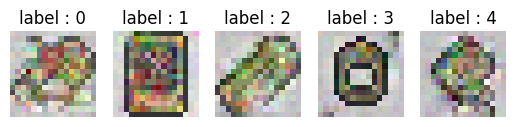

Epoch [14/20], Step [351/350], Loss_D: 0.020306, Loss_G: 4.710558: 100%|██████████| 350/350 [00:15<00:00, 22.05it/s] 


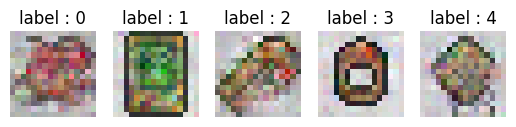

Epoch [15/20], Step [351/350], Loss_D: 0.102257, Loss_G: 2.639209: 100%|██████████| 350/350 [00:16<00:00, 21.62it/s] 


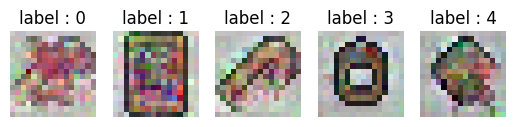

Epoch [16/20], Step [351/350], Loss_D: 0.063441, Loss_G: 3.358276: 100%|██████████| 350/350 [00:16<00:00, 21.84it/s]


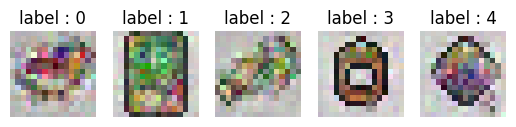

Epoch [17/20], Step [351/350], Loss_D: 0.029398, Loss_G: 6.172339: 100%|██████████| 350/350 [00:16<00:00, 21.63it/s] 


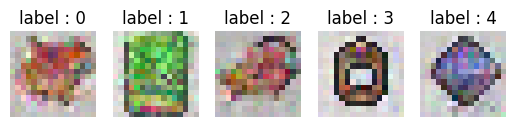

Epoch [18/20], Step [351/350], Loss_D: 0.004389, Loss_G: 6.993015: 100%|██████████| 350/350 [00:16<00:00, 21.85it/s]


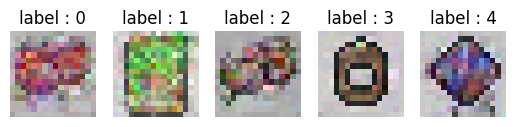

Epoch [19/20], Step [351/350], Loss_D: 0.035848, Loss_G: 4.583224: 100%|██████████| 350/350 [00:16<00:00, 21.79it/s] 


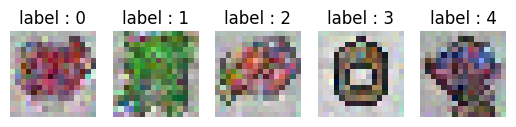

Epoch [20/20], Step [351/350], Loss_D: 0.069964, Loss_G: 3.234330: 100%|██████████| 350/350 [00:16<00:00, 21.77it/s] 


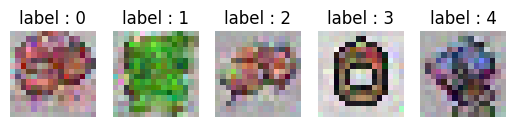

EPOCH 20 - FID score : 80.735638 (evaluation)
Saving gif file...


In [58]:
import copy
test_config = copy.deepcopy(config)

test_config.epoch = 20

train_loader = GANdataloader(train=True, batch_size=test_config.batch_size)

generator =  cGenerator(input_shape= test_config.input_shape,
                 latent_dim=test_config.latent_dim,num_classes=test_config.num_classes, nc = test_config.nc
                ).to(device)
discriminator = cDiscriminator(input_shape = test_config.input_shape,\
                               num_classes=test_config.num_classes).to(device)

trainer_test = train_cGAN(train_loader, \
                                generator = generator, discriminator = discriminator, \
                                device=device, config = test_config, fid_score_on=False,
                                save_model=True,img_show=True,evaluation_on=True)
results = trainer_test.train()
trained_generator = results['generator']

In [59]:
# load the trained model and loss history
trained_generator = results['generator']
trained_discriminator = results['discriminator']
loss_G = results['G_loss_history']
loss_D = results['D_loss_history']

### Loss curve of condtional GAN
The generator and discriminator losses of cGAN are plotted in the same figure.

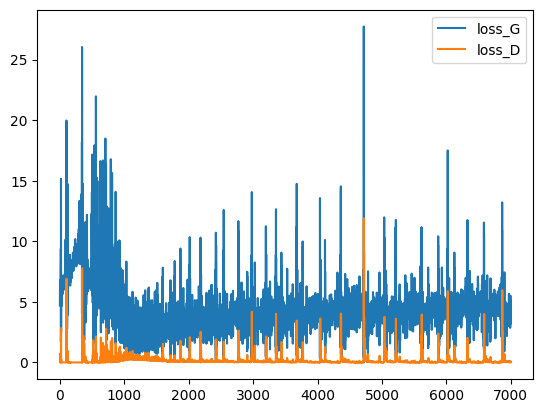

In [60]:
plt.plot(loss_G, label='loss_G')
plt.plot(loss_D, label='loss_D')
plt.legend()
plt.savefig(save_path+"cGAN_loss.png")
plt.show()

### Visualization of the generated image
The output image is generated with the random latent vector and label.

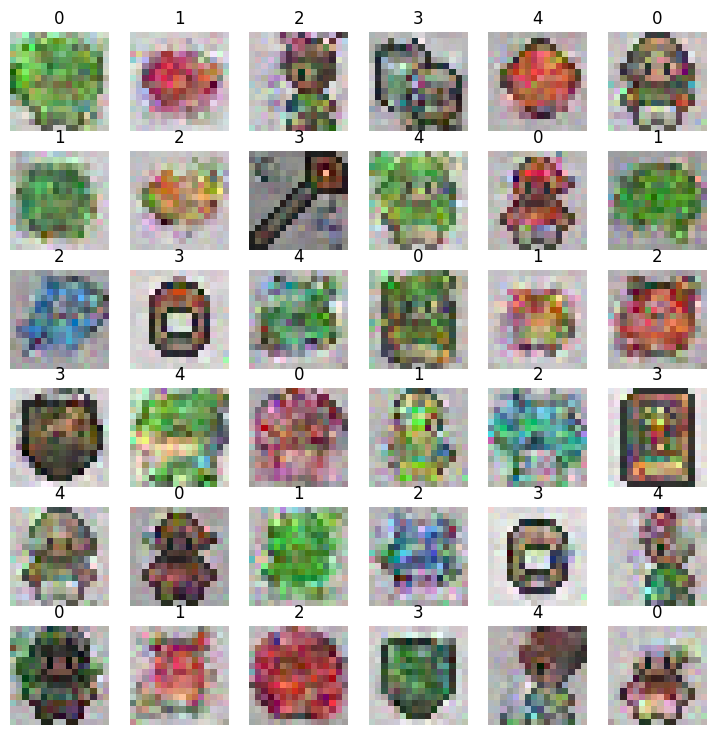

In [61]:
# fake image generation with your generator
# it produces image depending on the label
show_image_with_label(trained_generator,test_config,device=device,cols=6,rows=6)

## 5. Fréchet inception distance (FID) score
As seen from the above, training process of GAN is not stable and loss is not a good indicator for the performance of GAN. To evaluate the performance of GAN, the Fréchet inception distance is suggested. The FID score is defined as follows:
- FID score : $FID = ||\mu_{r} - \mu_{g}||^{2}_{2} + Tr(\Sigma_{r} + \Sigma_{g} - 2(\Sigma_{r}\Sigma_{g})^{1/2})$
    - $\mu_{r}$ : Mean of real image's feature `(2048,)`
    - $\mu_{g}$ : Mean of fake image's feature `(2048,)`
    - $\Sigma_{r}$ : Covariance of real image's feature `(batch_size, batch_size)`
    - $\Sigma_{g}$ : Covariance of fake image's feature `(batch_size, batch_size)`
    - All features are extracted from the pretrained  Inception-v3 network, which is defined in `PartialInceptionNetwork` class. `(batch_size, 2048)`
    

The function `calculate_fid` works as follows,
- preprocessing the images with `preprocess_images` function 
- The `get_activation` function extracts features from the `real_images` and `fake_images` via `get_activations` function
- The `get_statistics` function calculates mean and covariance of features extracted from `get_activations` function
- The `calculate_frechet_distance` function calculates FID score with the mean and covariance of features
- The `calculate_fid` function returns the FID score

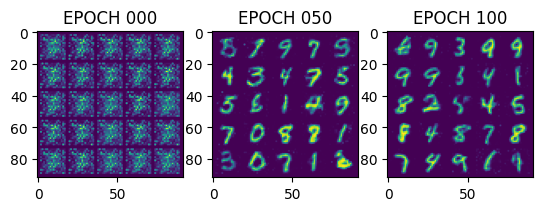

In [40]:
image1, image2, image3 = get_MNIST_image_and_visualize()

In [40]:
# Calculate FID score
inception_net = PartialInceptionNetwork()
fid_1 = calculate_fid(inception_net,image1, image2,batch_size=1,device=device)
fid_2 = calculate_fid(inception_net,image2, image3,batch_size=1,device=device)
print(f"fid_1 : {fid_1:.4f} >> fid_2 : {fid_2:.4f}")

fid_1 : 317.2869 >> fid_2 : 41.0402


## 6. Training GAN for image generation

Epoch [1/20], Step [351/350], Loss_D: 0.108547, Loss_G: 4.097517: 100%|██████████| 350/350 [00:21<00:00, 16.37it/s]


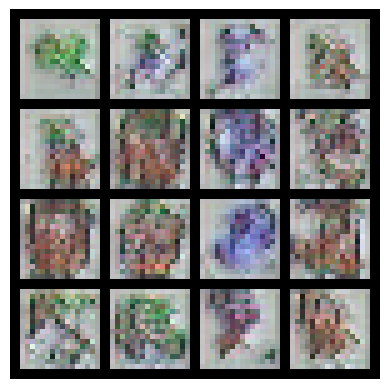

Epoch [2/20], Step [351/350], Loss_D: 0.116501, Loss_G: 3.455159: 100%|██████████| 350/350 [00:20<00:00, 16.96it/s] 


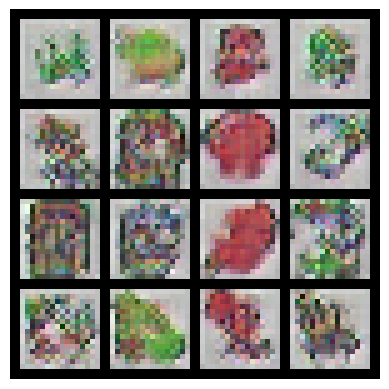

Epoch [3/20], Step [351/350], Loss_D: 1.410110, Loss_G: 0.034336: 100%|██████████| 350/350 [00:23<00:00, 15.05it/s] 


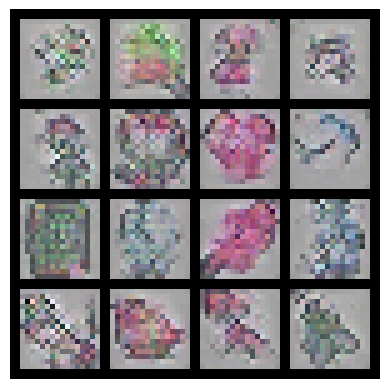

Epoch [4/20], Step [351/350], Loss_D: 0.178211, Loss_G: 4.039128: 100%|██████████| 350/350 [00:21<00:00, 16.29it/s] 


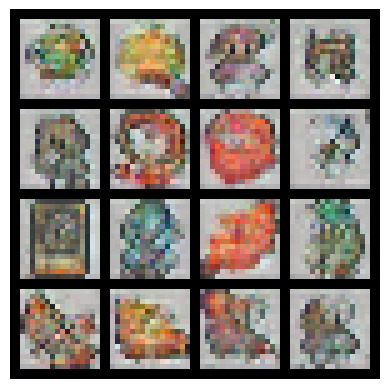

Epoch [5/20], Step [351/350], Loss_D: 0.039441, Loss_G: 4.203171: 100%|██████████| 350/350 [00:22<00:00, 15.84it/s] 


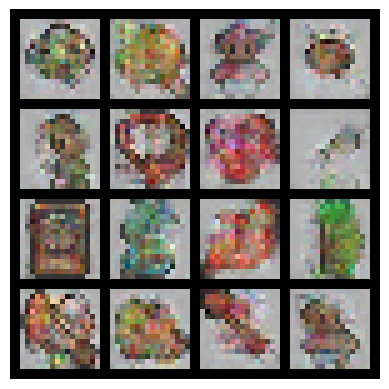

Epoch [6/20], Step [351/350], Loss_D: 0.028921, Loss_G: 4.572902: 100%|██████████| 350/350 [00:22<00:00, 15.56it/s]


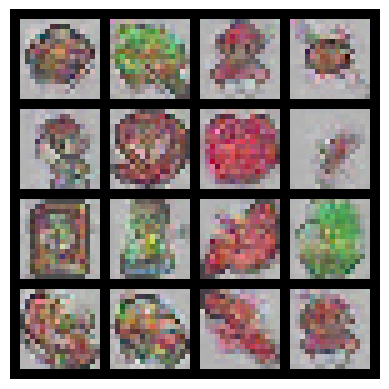

Epoch [7/20], Step [351/350], Loss_D: 0.145856, Loss_G: 3.713491: 100%|██████████| 350/350 [00:25<00:00, 13.99it/s] 


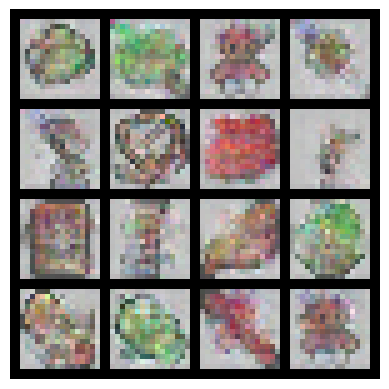

Epoch [8/20], Step [351/350], Loss_D: 0.396499, Loss_G: 8.827169: 100%|██████████| 350/350 [00:21<00:00, 15.91it/s] 


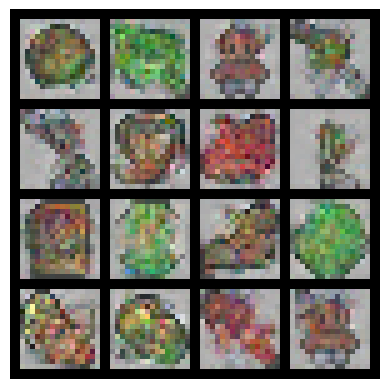

Epoch [9/20], Step [351/350], Loss_D: 0.084345, Loss_G: 1.730412: 100%|██████████| 350/350 [00:22<00:00, 15.69it/s] 


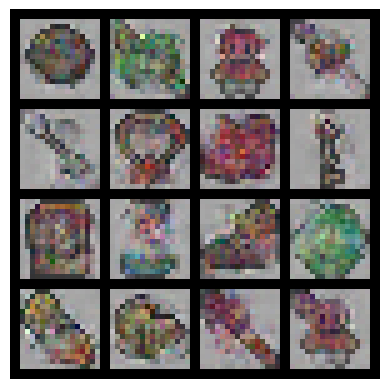

Epoch [10/20], Step [351/350], Loss_D: 0.063462, Loss_G: 3.321486: 100%|██████████| 350/350 [00:22<00:00, 15.75it/s] 


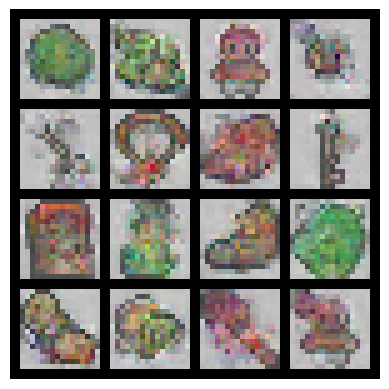

Epoch [11/20], Step [351/350], Loss_D: 0.035395, Loss_G: 3.746775: 100%|██████████| 350/350 [00:24<00:00, 14.21it/s] 


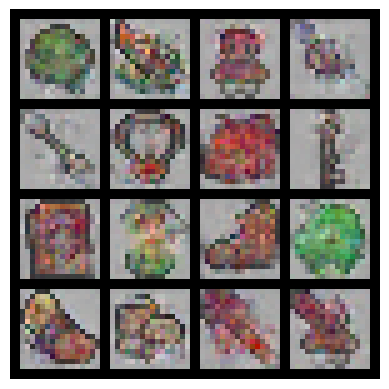

Epoch [12/20], Step [351/350], Loss_D: 0.059800, Loss_G: 2.829398: 100%|██████████| 350/350 [00:22<00:00, 15.90it/s]


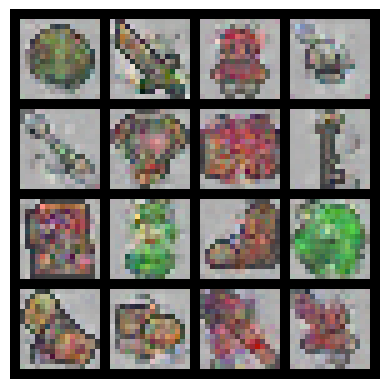

Epoch [13/20], Step [351/350], Loss_D: 0.012720, Loss_G: 5.247319: 100%|██████████| 350/350 [00:21<00:00, 16.36it/s] 


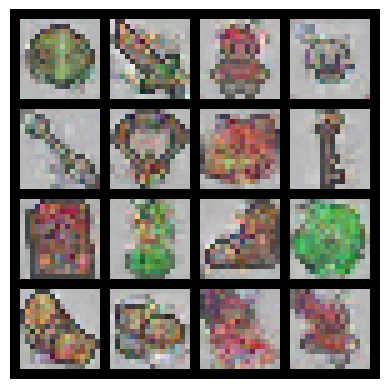

Epoch [14/20], Step [351/350], Loss_D: 0.030115, Loss_G: 4.865567: 100%|██████████| 350/350 [00:20<00:00, 16.89it/s] 


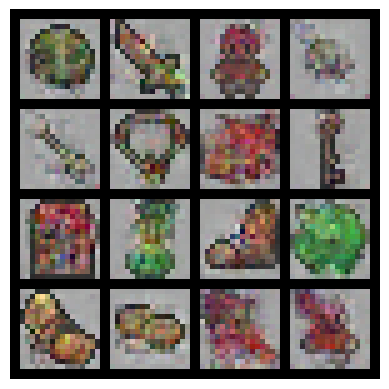

Epoch [15/20], Step [351/350], Loss_D: 0.011528, Loss_G: 5.574805: 100%|██████████| 350/350 [00:23<00:00, 15.04it/s]


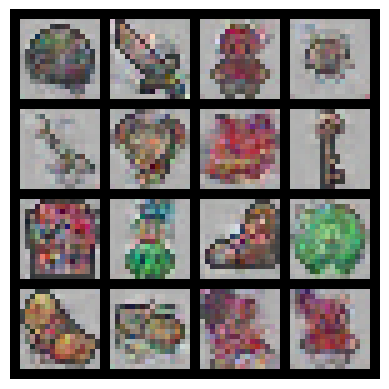

Epoch [16/20], Step [351/350], Loss_D: 0.011668, Loss_G: 6.806485: 100%|██████████| 350/350 [00:21<00:00, 16.57it/s] 


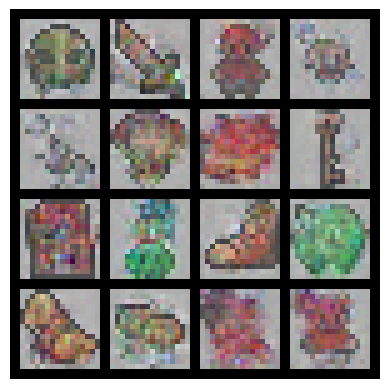

Epoch [17/20], Step [351/350], Loss_D: 0.036666, Loss_G: 4.752609: 100%|██████████| 350/350 [00:21<00:00, 15.92it/s]


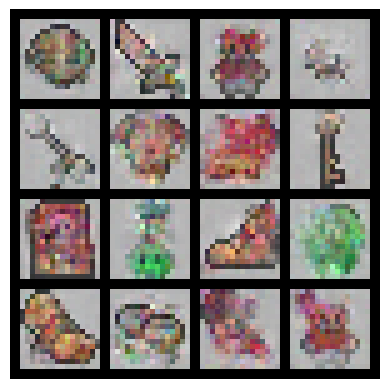

Epoch [18/20], Step [351/350], Loss_D: 0.307204, Loss_G: 6.311261: 100%|██████████| 350/350 [00:22<00:00, 15.88it/s] 


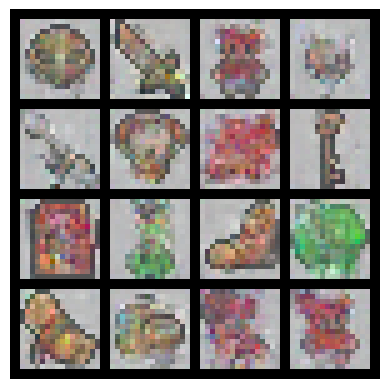

Epoch [19/20], Step [351/350], Loss_D: 0.015243, Loss_G: 6.343859: 100%|██████████| 350/350 [00:24<00:00, 14.16it/s]


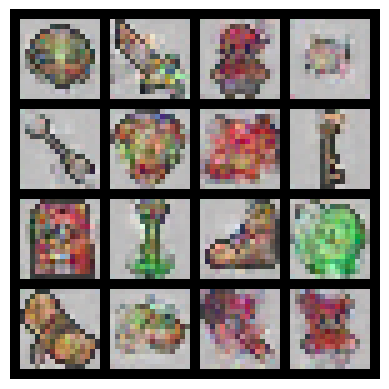

Epoch [20/20], Step [351/350], Loss_D: 0.041331, Loss_G: 6.603929: 100%|██████████| 350/350 [00:22<00:00, 15.80it/s] 


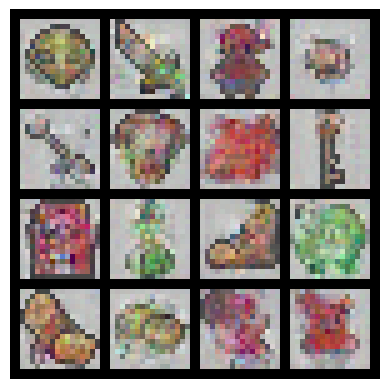

EPOCH 20 - FID score : 42.558546 (evaluation)
Saving gif file...


In [42]:
config.epoch = 20
import warnings

# Suppress the specific UserWarning
warnings.filterwarnings("ignore", message="The default value of the antialias parameter.*")


train_loader = GANdataloader(train=True, batch_size=config.batch_size)

generator = Generator(latent_dim = config.latent_dim, nc = config.nc).to(device)
discriminator = Discriminator(nc=config.nc).to(device)



trainer_test = train_GAN(train_loader, \
                                generator = generator, discriminator = discriminator, \
                                device=device, config = config, fid_score_on=False,
                                save_model=True,img_show=True,evaluation_on=True)
results = trainer_test.train()


In [43]:
# load the trained model and loss history
trained_generator = results['generator']
trained_discriminator = results['discriminator']
loss_G = results['G_loss_history']
loss_D = results['D_loss_history']

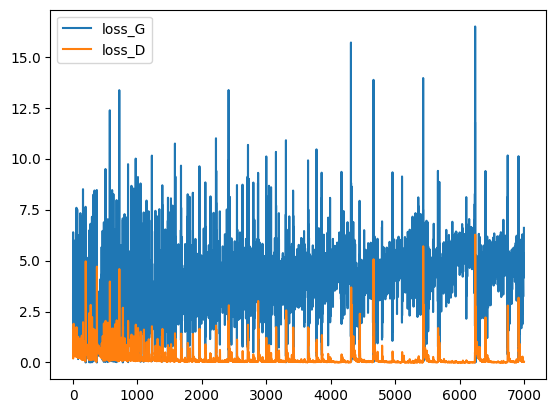

In [46]:
plt.plot(loss_G, label='loss_G')
plt.plot(loss_D, label='loss_D')
plt.legend()
plt.savefig(save_path+"GAN_loss.png")
plt.show()

### Visualization of the generated image
- Images generated by the trained GAN.

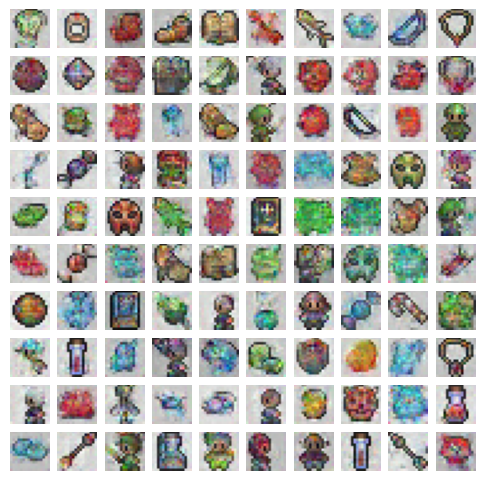

In [47]:
# fake image generation
show_image_with_GAN(trained_generator,config,device=device,cols=10,rows=10)

## Acknowledgments
- Dataset : Sprites by ElvGames, [FrootsnVeggies](https://zrghr.itch.io/froots-and-veggies-culinary-pixels) and [kyrise](https://kyrise.itch.io/)

**References**




 Goodfellow, I.J. et al. (2014), *Generative Adversarial Networks*, arXiv.org. Available at: https://arxiv.org/abs/1406.2661  